# Benchmark of building an array with numba

Here I try out different ways of making arrays of tuples with Numba where the number of tuples that need to be produced is not known in advance. The fastest way is to make a list of tuples, and then convert this into a Numpy array before returning. The *baseline* shown in the last plot is the fastest possible way of pre-allocating a Numpy array with the right size upfront, but this cannot be used if the number of tuples is not known in advance.

In [1]:
import numba as nb
import numpy as np
import awkward as ak
print(f"{nb.__version__=}")
print(f"{ak.__version__=}")

nb.__version__='0.53.1'
ak.__version__='1.1.2'


In [2]:
@nb.njit
def make0(n):
    r = np.empty((n, 4))
    for i in range(n):
        # simulate some work
        x = np.random.rand()
        y = np.random.rand()
        z = np.random.rand()
        t = np.random.rand()
        r[i,0] = x
        r[i,1] = y
        r[i,2] = z
        r[i,3] = t
    return r

make0(3)

array([[0.25473852, 0.47593451, 0.04606011, 0.55805331],
       [0.77287874, 0.52879803, 0.91944361, 0.98775869],
       [0.01221509, 0.30608935, 0.90908168, 0.07629862]])

In [3]:
%timeit make0(1000)

26.1 µs ± 1.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [4]:
@nb.njit
def make1(n):
    r = []
    for i in range(n):
        # simulate some work
        x = np.random.rand()
        y = np.random.rand()
        z = np.random.rand()
        t = np.random.rand()
        r.append((x, y, z, t))
    return np.asarray(r)

make1(3)

array([[0.40883519, 0.14577046, 0.20275019, 0.24327066],
       [0.7325605 , 0.76214408, 0.47819782, 0.93920595],
       [0.24872141, 0.92187207, 0.6691103 , 0.5643187 ]])

In [5]:
%timeit make1(1000)

36.9 µs ± 1.55 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
@nb.njit
def make2(n):
    r = []
    for i in range(n):
        ri = []
        # simulate some work
        x = np.random.rand()
        y = np.random.rand()
        z = np.random.rand()
        t = np.random.rand()
        ri.append(x)
        ri.append(y)
        ri.append(z)
        ri.append(t)        
        r.append(ri)
    return np.asarray(r)

make2(3)

array([[0.13088925, 0.25692562, 0.48062596, 0.39696723],
       [0.3552985 , 0.99054454, 0.38778594, 0.94289909],
       [0.76625383, 0.01588522, 0.43885749, 0.73488083]])

In [7]:
%timeit make2(1000)

419 µs ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
@nb.njit
def make3(n):
    r = []
    for i in range(n):
        # simulate some work
        x = np.random.rand()
        y = np.random.rand()
        z = np.random.rand()
        t = np.random.rand()
        r.append(x)
        r.append(y)
        r.append(z)
        r.append(t)
    return np.array(r).reshape((n, 4))

make3(3)

array([[0.60766162, 0.66840636, 0.2019663 , 0.92669818],
       [0.69739471, 0.33933288, 0.9356699 , 0.61572307],
       [0.43173953, 0.40320305, 0.80278753, 0.46843452]])

In [9]:
%timeit make3(1000)

49.8 µs ± 2.36 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
@nb.njit
def _make4(b, n):
    for i in range(n):
        x = np.random.rand()
        y = np.random.rand()
        z = np.random.rand()
        t = np.random.rand()
        b.begin_tuple(4)
        b.index(0).append(x)
        b.index(1).append(y)
        b.index(2).append(z)
        b.index(3).append(t)
        b.end_tuple()
    return b

def make4(n):
    return _make4(ak.ArrayBuilder(), n).snapshot()

make4(3)

<Array [(0.376, 0.269, 0.149, ... 0.409, 0.38)] type='3 * (float64, float64, flo...'>

In [11]:
%timeit make4(1000)

356 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
@nb.njit
def _make5(b, n):
    for i in range(n):
        x = np.random.rand()
        y = np.random.rand()
        z = np.random.rand()
        t = np.random.rand()
        b.begin_list()
        b.append(x)
        b.append(y)
        b.append(z)
        b.append(t)
        b.end_list()
    return b

def make5(n):
    return _make5(ak.ArrayBuilder(), n).snapshot()

make5(3)

<Array [[0.216, 0.481, ... 0.247, 0.0629]] type='3 * var * float64'>

In [13]:
%timeit make5(1000)

263 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
import timeit
import matplotlib.pyplot as plt

n = np.geomspace(1, 1000000, 20).astype(int)

ys = []
for fn in (make0, make1, make2, make3, make4, make5):
    y = []
    for ni in n:
        m, t = timeit.Timer(lambda : fn(ni)).autorange()
        y.append(t/m)
    ys.append(y)

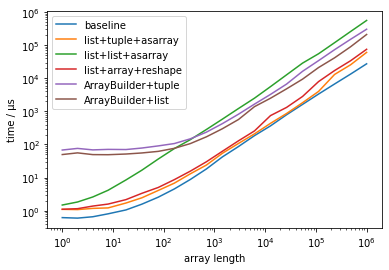

In [15]:
for y, label in zip(ys, ("baseline",
                         "list+tuple+asarray",
                         "list+list+asarray",
                         "list+array+reshape",
                         "ArrayBuilder+tuple",
                         "ArrayBuilder+list")):
    plt.plot(n, np.divide(y, 1e-6), label=label)
plt.legend()
plt.xlabel("array length")
plt.ylabel("time / μs")
plt.loglog();